In [54]:


import torch
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import cv2
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import time
import os
import PIL
from PIL import Image
import seaborn as sns
cudnn.benchmark = True

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cuda device


In [55]:
BASE_DIR = 'Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet'
disease_label_from_category = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}



In [56]:
df = pd.read_parquet(BASE_DIR, engine="pyarrow")
df.head()



,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


In [57]:
test = pd.read_parquet(BASE_DIR, engine="pyarrow")
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

In [58]:
df['img_arr'] = df['image'].apply(dict_to_image)
df.drop("image", axis=1, inplace=True)
df.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [59]:
test['img_arr'] = test['image'].apply(dict_to_image)
test.drop("image", axis=1, inplace=True)

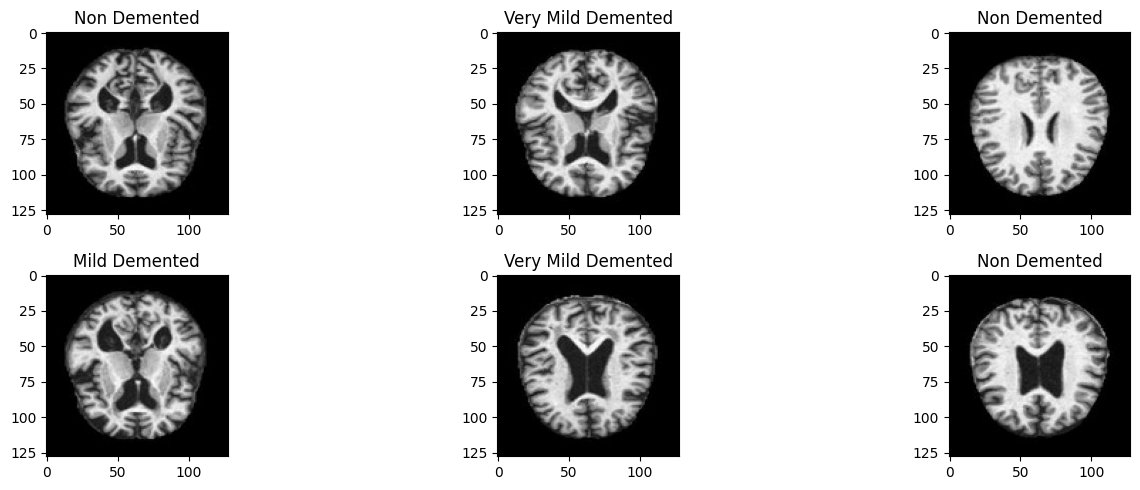

In [60]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
axs = ax.flatten()
for axes in axs:
    rand = np.random.randint(0, len(df))
    axes.imshow(df.iloc[rand]['img_arr'], cmap="gray")
    axes.set_title(disease_label_from_category[df.iloc[rand]['label']])
plt.tight_layout()
plt.show()

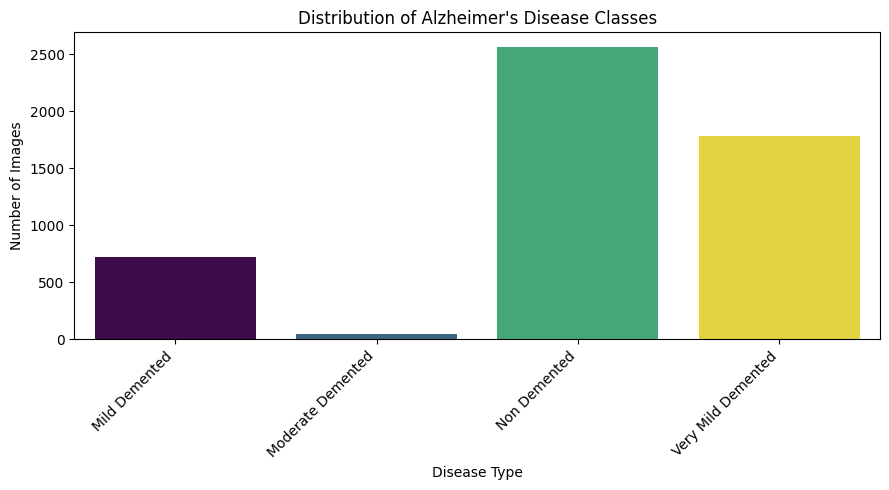

In [61]:
plt.figure(figsize=(9, 5))
sns.countplot(x=df['label'], hue=df['label'], palette='viridis', legend=False)
plt.title("Distribution of Alzheimer's Disease Classes")
plt.xlabel("Disease Type")
plt.ylabel("Number of Images")
plt.xticks(np.arange(0, 4, 1), labels=[disease_label_from_category[i] for i in range(4)], rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [62]:
train_transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=45),
    v2.GaussianBlur(kernel_size=3),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485], std=[0.229])
])

test_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485], std=[0.229])
])

In [63]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]["img_arr"]
        label = self.dataframe.iloc[idx]["label"]
        
        if self.transform:

            image = Image.fromarray(image)
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [64]:
import torch.nn as nn

class AlzheimerCNN(nn.Module):
    def __init__(self):
        super(AlzheimerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 4)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.pool(x)  
        x = self.leaky_relu(self.conv2(x))
        x = self.pool(x)
        x = self.leaky_relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 16 * 16)
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [65]:
learning_rate = 0.001
NEPOCHS = 50
batch_size = 16

In [66]:
train_dataset = ImageDataset(df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [67]:
def train_model(model, loader, optimizer, num_epochs=NEPOCHS):
    
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    for epoch in tqdm.tqdm(range(num_epochs), total=num_epochs):
        running_loss = 0.0
        for i, data in enumerate(loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        epoch_loss = running_loss / len(loader)
        train_losses.append(epoch_loss)

    print('Finished Training')
    return model, train_losses

In [68]:
model = AlzheimerCNN().to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
model, train_losses = train_model(model, train_loader, optimizer)

100%|██████████| 50/50 [02:19<00:00,  2.79s/it]

Finished Training


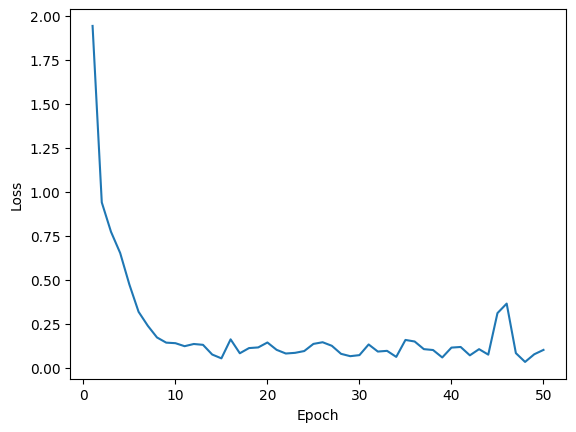

In [69]:
plt.plot(np.arange(1, 51), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [70]:
TEST_DIR = 'Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet'
disease_label_from_category = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}

def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

test = pd.read_parquet(TEST_DIR, engine="pyarrow")
test['img_arr'] = test['image'].apply(dict_to_image)
test.drop("image", axis=1, inplace=True)

In [71]:
class ImageDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]["img_arr"]
        label = self.dataframe.iloc[idx]["label"]
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) 
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [72]:
batch_size = 16
test_dataset = ImageDataset(test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [73]:
def predict(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

def result_summary(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Accuracy: {accuracy:.4f}')

    conf_matrix = confusion_matrix(true_labels, predictions)
    print('Confusion Matrix:')
    print(conf_matrix)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', 
                xticklabels=[disease_label_from_category[i] for i in range(4)],
                yticklabels=[disease_label_from_category[i] for i in range(4)])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

    class_report = classification_report(true_labels, predictions,target_names=[disease_label_from_category[i] for i in range(4)])
    print('Classification Report:')
    print(class_report)

Accuracy: 0.9672
Confusion Matrix:
[[159   1   4   8]
 [  0  14   1   0]
 [  1   0 619  14]
 [  2   0  11 446]]


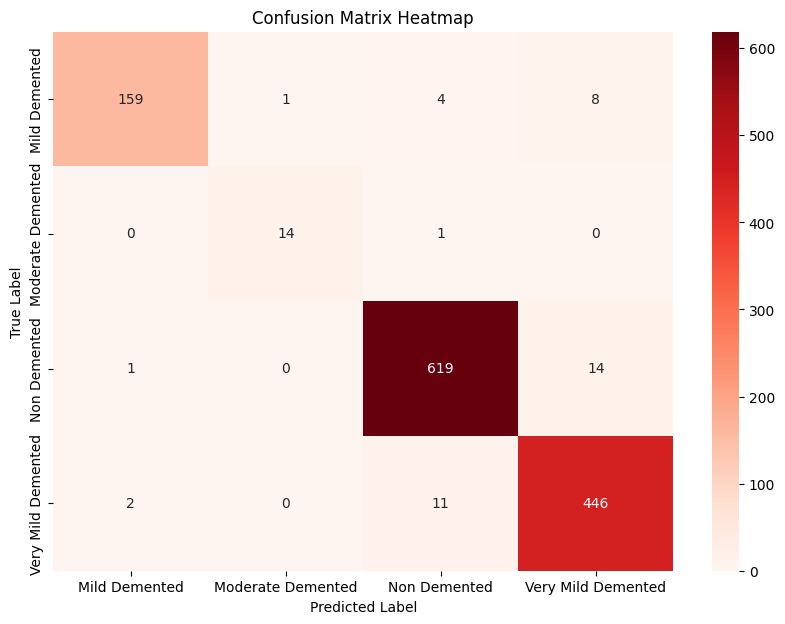

Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.98      0.92      0.95       172
 Moderate Demented       0.93      0.93      0.93        15
      Non Demented       0.97      0.98      0.98       634
Very Mild Demented       0.95      0.97      0.96       459

          accuracy                           0.97      1280
         macro avg       0.96      0.95      0.96      1280
      weighted avg       0.97      0.97      0.97      1280



In [74]:
predictions, true_labels = predict(model, test_loader, device)
result_summary(predictions, true_labels)